In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
#from ncps.wirings import AutoNCP
#from ncps.tf import LTC
import tensorflow as tf
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape


def create_cnn_model(input_shape):

    model = Sequential()
    # Convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())  # Add batch normalization
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())  # Add batch normalization
    #model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    # Flatten layer
    model.add(Flatten())

    # Dense layers
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))

    # Output layer
    model.add(Dense(128 * 128 * 1, activation='sigmoid'))  # Adjust the output shape to match the label shape

    # Reshape output to match label shape
    model.add(Reshape((128, 128, 1)))

    return model
# Model Definition Function
def create_lstm_model():
#height, width, channels = (78, 200, 3)

   # ncp = LTC(AutoNCP(32, output_size=8), return_sequences=True)
    model = models.Sequential([
        layers.LSTM(64, return_sequences=True, input_shape=(128, 128)),  # LSTM layer with 64 units
        #BatchNormalization(),
        layers.LSTM(64, return_sequences=True),  # Second LSTM layer with 64 units
         BatchNormalization(),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Activation("linear")),
        #layers.LayerNormalization(),
        layers.Dense(128),
       # BatchNormalization()
    ])
    return model

In [2]:

def plot_accuracy(history):
    plt.figure(figsize=(10, 4))

    # Plot training & validation accuracy values
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Function to plot predicted vs target spectrograms
def plot_spectrograms(y_val, y_pred):
    num_samples_to_visualize = 3
    sample_indices = np.random.choice(y_val.shape[0], num_samples_to_visualize, replace=False)

    for idx in sample_indices:
        plt.figure(figsize=(12, 6))

        # Display target spectrogram
        plt.subplot(1, 2, 1)
        plt.imshow(y_val[idx], cmap='viridis', origin='lower', aspect='auto')
        plt.colorbar()
        plt.title(f"Target Spectrogram - Sample {idx}")

        # Display predicted spectrogram
        plt.subplot(1, 2, 2)
        plt.imshow(y_pred[idx], cmap='viridis', origin='lower', aspect='auto')
        plt.colorbar()
        plt.title(f"Predicted Spectrogram - Sample {idx}")

        plt.tight_layout()
        plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
x_train (900, 128, 128)
x_val (100, 128, 128)
y_train (900, 128, 128)
y_val (100, 128, 128)
Shape of y_val: (100, 128, 128)
Epoch 1/35
45/45 [==============================] - 104s 2s/step - loss: 0.1608 - mae: 0.3066 - val_loss: 0.2978 - val_mae: 0.5323
Epoch 2/35
45/45 [==============================] - 85s 2s/step - loss: 0.0223 - mae: 0.1161 - val_loss: 0.2632 - val_mae: 0.4989
Epoch 3/35
45/45 [==============================] - 85s 2s/step - loss: 0.0199 - mae: 0.1137 - val_loss: 0.2413 - val_mae: 0.4767
Epoch 4/35
45/45 [==============================] - 84s 2s/step - loss: 0.0196 - mae: 0.1134 - val_loss: 0.2246 - val_mae: 0.4593
Epoch 5/35
45/45 [==============================] - 86s 2s/step - loss: 0.0194 - mae: 0.1132 - val_loss: 0.2083 - val_mae: 0.4416
Epoch 6/35
45/45 [==============================] - 83s 2s/step - loss: 0.0194 - mae: 0.1132 - v

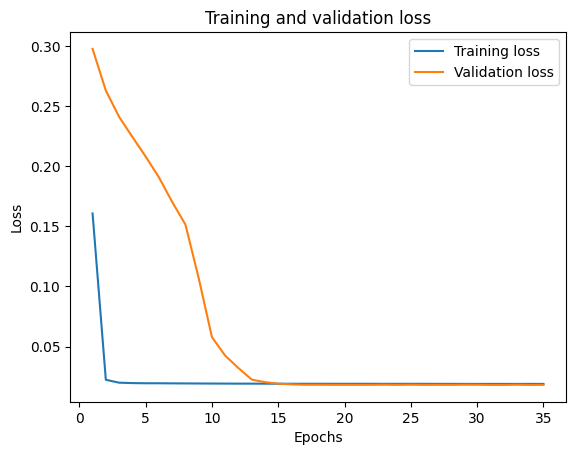

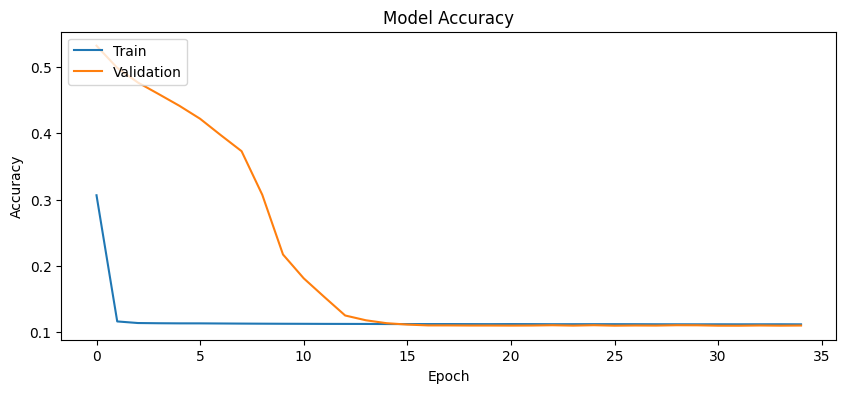

4/4 [==============================] - 3s 730ms/step


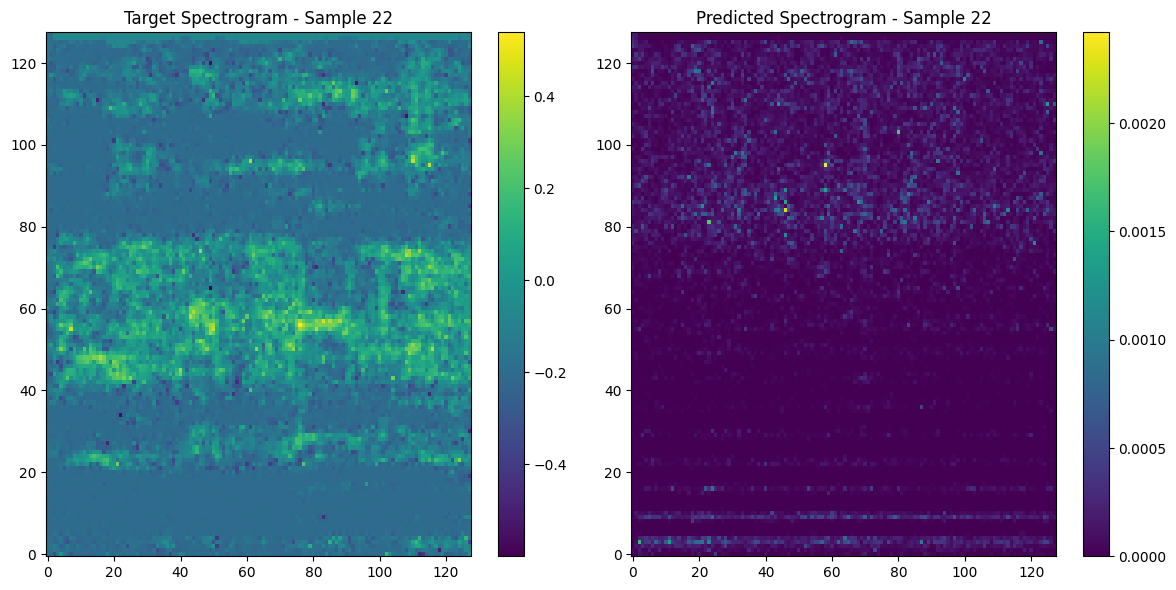

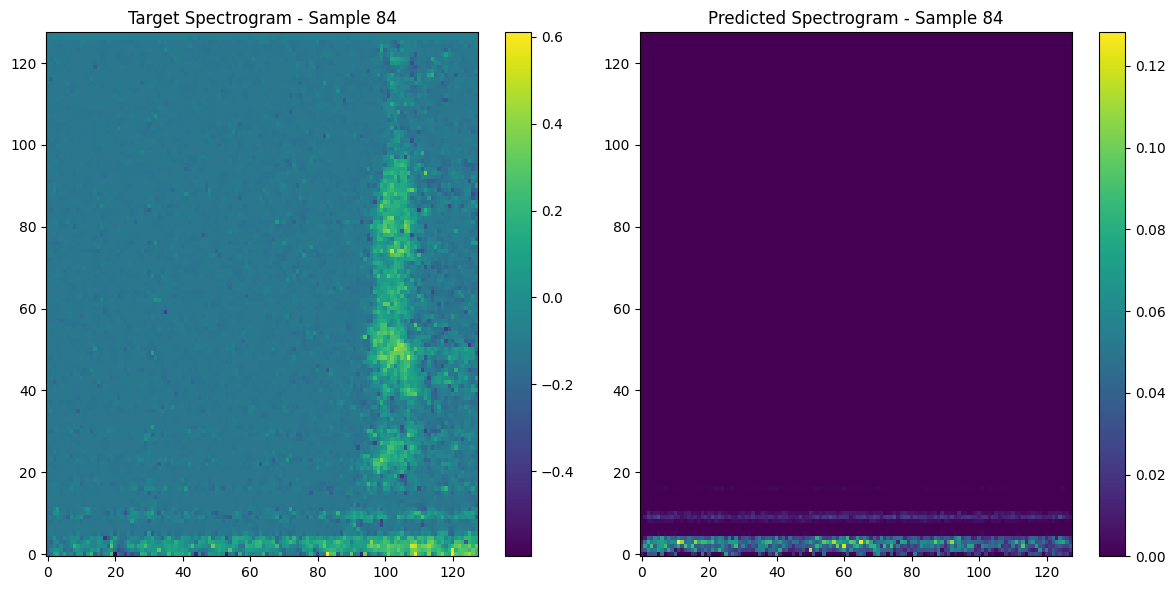

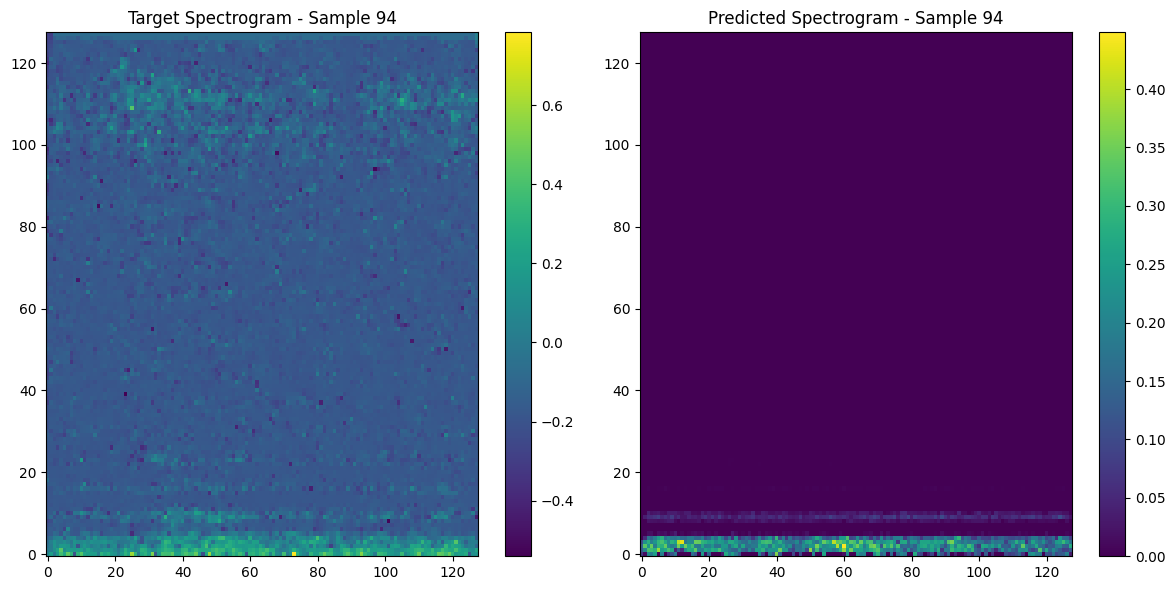

In [7]:
from google.colab import drive
drive.mount('/content/drive')

# Scaling functions
def scaled_in(matrix_spec):
    return (matrix_spec + 46) / 50

def scaled_ou(matrix_spec):
    return (matrix_spec - 6) / 82

# Data Preparation Function
def prepare_data(path_save_spectrogram):
    X_in = np.load(os.path.join(path_save_spectrogram, 'noisy_voice_amp_db.npy'))
    X_ou = np.load(os.path.join(path_save_spectrogram, 'voice_amp_db.npy'))
    X_ou = X_in - X_ou
    X_in = scaled_in(X_in)
    X_ou = scaled_ou(X_ou)

    # Split into training and validation
    x_train, x_val, y_train, y_val = train_test_split(X_in, X_ou, test_size=0.10, random_state=42)

    # Reshape for LSTMs (128 timesteps, 128 features)
    x_train_reshaped = x_train.reshape((x_train.shape[0], 128, 128))
    x_val_reshaped = x_val.reshape((x_val.shape[0], 128, 128))
    y_train_reshaped = y_train.reshape((y_train.shape[0], 128, 128))
    y_val_reshaped = y_val.reshape((y_val.shape[0], 128, 128))

    return x_train_reshaped, x_val_reshaped, y_train_reshaped, y_val_reshaped



# Training and Evaluation Function
def train_and_evaluate_model(model, x_train, x_val, y_train, y_val):
    #lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
   # initial_learning_rate=0.01,
   # decay_steps=563,
    #decay_rate=0.9,
    #staircase=True
   # )

    print('x_train',x_train.shape)
    print('x_val',x_val.shape)
    print('y_train',y_train.shape)
    print('y_val',y_val.shape)

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='mse',
        metrics=['mae']
    )

    # ModelCheckpoint to save the best model
    model_checkpoint_path = 'best_model_lstm.keras'
    checkpoint = ModelCheckpoint(
        model_checkpoint_path,
        verbose=1,
        monitor='val_loss',
        save_best_only=True,
        mode='auto'
    )

    print("Shape of y_val:", y_val.shape)
   # print("Shape of y_pred:", y_pred.shape)
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=35, batch_size=20, verbose=1)

    y_pred = model.predict(x_val)

    # Reshape target and prediction for MSE calculation
    y_val_flat = y_val.reshape(y_val.shape[0], -1)
    y_pred_flat = y_pred.reshape(y_pred.shape[0], -1)
    # Compute MSE
    mse = mean_squared_error(y_val_flat, y_pred_flat)
    print(f"Mean Squared Error (MSE): {mse}")

    # Compute SNR
    def compute_snr(target, prediction):
        noise = target - prediction
        snr = 10 * np.log10(np.mean(target**2) / np.mean(noise**2))
        return snr

    snr = compute_snr(y_val_flat, y_pred_flat)
    print(f"Signal-to-Noise Ratio (SNR): {snr} dB")


    # Plot training and validation loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plot_accuracy(history)

    # Plot predicted vs target spectrograms
    y_pred = model.predict(x_val)
    plot_spectrograms(y_val, y_pred)


    return history

# Main Workflow
def main():
    # Data Preparation
    path_save_spectrogram = '/content/drive/MyDrive/npy/New1000/'
    x_train_reshaped, x_val_reshaped, y_train_reshaped, y_val_reshaped = prepare_data(path_save_spectrogram)
    input_shape = (128, 128, 1)
    # Create the model
    lstm_model = create_cnn_model(input_shape)
    #lstm_model = create_lstm_model()

    # Train and evaluate the model
    train_and_evaluate_model(lstm_model, x_train_reshaped, x_val_reshaped, y_train_reshaped, y_val_reshaped)

    # Save the model architecture and weights
    model_json = lstm_model.to_json()
    with open('model_lstm.json', 'w') as json_file:
        json_file.write(model_json)

    lstm_model.save_weights('model_lstm_weights.keras')

# Run the main function
if __name__ == "__main__":
    main()
